2b

Dataset and DataLoader

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import requests
from torchvision.datasets import ImageFolder
from torchvision import models
from PIL import Image
from shutil import copyfile
import os

In [3]:
os.chdir('/content/drive/MyDrive/MLDL_project')
from datasets.cityscapes import CityscapesDataset
from datasets.gta5 import GTA5

In [4]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

lbl_transform = transforms.Compose([
    transforms.Resize((512,1024), interpolation=Image.Resampling.NEAREST),
])

In [5]:
train_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', transform=[transform,lbl_transform], split='train')
val_dataset = CityscapesDataset('/content/drive/MyDrive/MLDL_project/datasets/Cityspaces', transform=[transform,lbl_transform], split='val')

In [6]:
# Create a DataLoader
from torch.utils.data import DataLoader
dataloader_train = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)

In [7]:
num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)

print(f'Number of training samples: {num_train_samples}')
print(f'Number of validation samples: {num_val_samples}')

Number of training samples: 1572
Number of validation samples: 500


Build model

In [8]:
# Load pre-trained model

from models.bisenet.build_bisenet import BiSeNet
model = BiSeNet(num_classes = 19, context_path='resnet18').cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 236MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 192MB/s]


Trainning and validation process

In [9]:
from train import train
from validate import validation

In [11]:
import torch.optim as optim
from utils import poly_lr_scheduler
from timeit import default_timer as timer

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=2.5e-2, momentum=0.9, weight_decay=1e-4)

# Start the timer
start_time = timer()

# training model
epochs = 50

miou_train_list = []
miou_val_list = []
models = []
for epoch in range(epochs):
    curr_lr = poly_lr_scheduler(optimizer = optimizer, init_lr = 2.5e-2, iter = epoch, lr_decay_iter=1, max_iter=epochs, power=0.9)
    print(f"Current learning rat: {curr_lr}")
    _, miou_train, miou_per_class_train = train(epoch, model, dataloader_train, criterion, optimizer)
    # every 5 epochs print the miou and loss of validation set
    if epoch % 5 == 0:
      _, miou_val, miou_per_class_val = validation(model, dataloader_val, criterion)
      miou_train_list.append(miou_train)
      miou_val_list.append(miou_val)
      models.append(model.state_dict())
    print("\n")

_, miou_val, miou_per_class_val = validation(model, dataloader_val, criterion)
miou_train_list.append(miou_train)
miou_val_list.append(miou_val)
models.append(model.state_dict())

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Current learning rat: 0.025
Epoch1 Avg. Training Loss: 0.4170318108222206, mIoU: 0.3140645259406313
Avg. Validation Loss: 0.4182618232000442, mIoU: 0.33468474205525345


Current learning rat: 0.024549546664914382
Epoch2 Avg. Training Loss: 0.31148641582975534, mIoU: 0.4136759795407922


Current learning rat: 0.024098173031463777
Epoch3 Avg. Training Loss: 0.25154313059325145, mIoU: 0.5288436076866418


Current learning rat: 0.023645857984465803
Epoch4 Avg. Training Loss: 0.21391927099167393, mIoU: 0.5978214741837415


Current learning rat: 0.023192579464083207
Epoch5 Avg. Training Loss: 0.19007017921070157, mIoU: 0.6410620145492562


Current learning rat: 0.022738314402074057
Epoch6 Avg. Training Loss: 0.17306946422242878, mIoU: 0.6729949468875955
Avg. Validation Loss: 0.29928070306777954, mIoU: 0.4923148530014738


Current learning rat: 0.022283038652225
Epoch7 Avg. Training Loss: 0.16246749929667728, mIoU: 0.6918305114641363


Current learning rat: 0.02182672691429215
Epoch8 Avg. Tra

In [12]:
# save best model
import os
DIR = '/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/'
if not os.path.exists(DIR):
    os.makedirs(DIR)
PATH = DIR + f'biseNet_epoch{epochs}.pth'

# delete old model files
if os.path.exists(PATH):
    os.remove(PATH)

model = BiSeNet(num_classes = 19, context_path='resnet18').cuda()
model.load_state_dict(models[np.argmax(np.array(miou_val_list))])
torch.save(model.state_dict(), PATH)

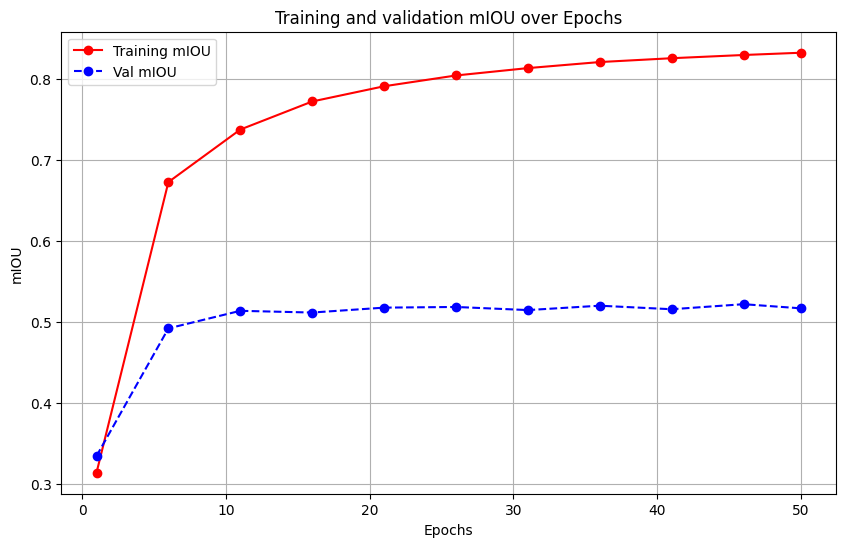

In [18]:
# visualization
import matplotlib.pyplot as plt

epochs_list = list(np.arange(1, epochs+1, 5)) + [50]
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, miou_train_list, marker='o', linestyle='-', color='r', label='Training mIOU')
plt.plot(epochs_list, miou_val_list, marker='o', linestyle='--', color='b', label='Val mIOU')

plt.title('Training and validation mIOU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mIOU')

plt.legend()
plt.grid(True)
plt.show()

Flops and Number of parameters

In [19]:
saved_state_dict = torch.load('/content/drive/MyDrive/MLDL_project/models/bisenet/trained_models/biseNet_epoch50.pth')
model.load_state_dict(saved_state_dict)

<All keys matched successfully>

In [20]:
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=5ccdd6152688b48249798a882fc7059a421fba625b380a4338d050254b576440
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=236b376d853c0833480547fcebf2c12b049e16a9855d889e953dca783d432512
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [21]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

model.eval()
height = train_dataset[0][0].shape[0]
width = train_dataset[0][0].shape[1]
image = torch.zeros((1, 3, height, width)).cuda()

flops = FlopCountAnalysis(model, image)
print(flops)

total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 12581672


In [22]:
#more detail information about number of parameters and flops
print(flop_count_table(flops))

| module                                      | #parameters or shape   | #flops     |
|:--------------------------------------------|:-----------------------|:-----------|
| model                                       | 12.582M                | 0.302G     |
|  saptial_path                               |  0.371M                |  29.327M   |
|   saptial_path.convblock1                   |   1.856K               |   0.95M    |
|    saptial_path.convblock1.conv1            |    1.728K              |    0.885M  |
|    saptial_path.convblock1.bn               |    0.128K              |    65.536K |
|   saptial_path.convblock2                   |   73.984K              |   9.47M    |
|    saptial_path.convblock2.conv1            |    73.728K             |    9.437M  |
|    saptial_path.convblock2.bn               |    0.256K              |    32.768K |
|   saptial_path.convblock3                   |   0.295M               |   18.907M  |
|    saptial_path.convblock3.conv1            |    0.2

Latency and FPS

In [23]:
from utils import latency_fps

In [24]:
latency_fps(model, train_dataset, transform, device = 'cuda', iterations = 1000)

Mean Latency: 15.47547960281372 ms
Std Latency: 1.2429735473684378 ms
Mean FPS: 65.67706876309116
Std FPS: 14.737639078865303
